In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read the data
df = pd.read_csv('../data/mydata.csv')

# Print the first few rows of the data
df.head()

/var/folders/0n/w0w76l850xd5bkqpcpl6v0rr0000gn/T/ipykernel_2993/93828000.py:7: DtypeWarning: Columns (3,5,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/mydata.csv')


,Unnamed: 0,issuer,domicile,state,notifying_party,domicile_not,total_participation_shares,participation_instruments,aggregation,publication,direct_participation,single_rights_1,attributable_participation,single_rights_2,single_rights_3,gazette_1,gazette_2,state_2,date,table_date
0,1,A.A.A. Aktiengesellschaft Allgemeine Anlagever...,Frankfurt am Main,NaN,ROTHENBERGER Vermögensverwaltung GbR 4xS,NaN,29.62,NaN,NaN,1999-05-11,29.62,NaN,NaN,NaN,NaN,Börsen-Zeitung,NaN,NaN,NaN,200001.0
1,2,A.A.A. Aktiengesellschaft Allgemeine Anlagever...,Frankfurt am Main,NaN,"Rothenberger, Dr., Helmut",NaN,11.93,NaN,NaN,1995-10-07,11.93,NaN,NaN,NaN,NaN,Börsen-Zeitung,NaN,NaN,NaN,200001.0
2,3,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,"Schneider, Franz Jürgen",NaN,33.10,NaN,NaN,1998-07-08,33.10,NaN,NaN,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0
3,4,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,3i Group plc,NaN,23.34,NaN,NaN,1998-07-08,0.00,NaN,23.34,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0
4,5,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,3i Deutschland Gesellschaft für Industriebetei...,NaN,23.34,NaN,NaN,1998-07-08,23.34,NaN,NaN,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0


### Notes

I noticed late entries don't have a table date, it seems to disappear somewhere in between. I will plot that below and on that occasion also have a look at a few other columns.

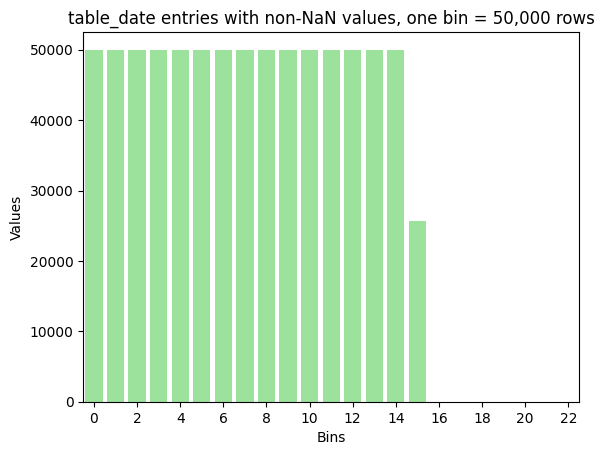

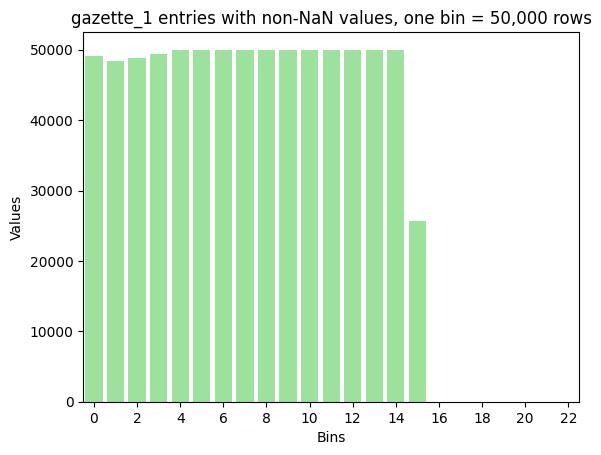

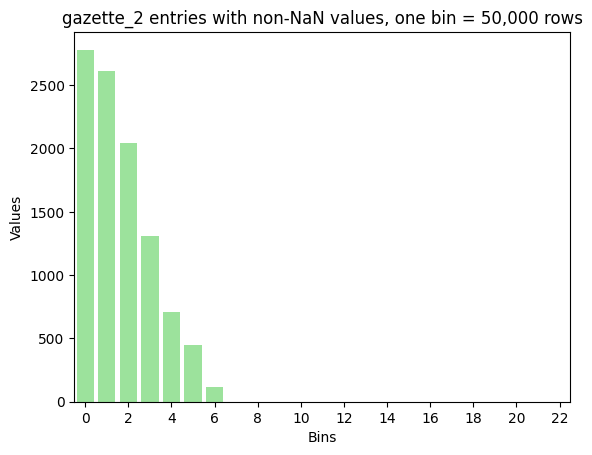

In [37]:
# Create bins, i.e. slices of the DataFrame, that each contain 50,000 rows

def plot_nan_values(column):
    bins = [df.index[i:i+50000] for i in range(0,len(df),50000)]

    # Create an empty list to store the counts of non-NaN values in the "table_date" column
    counts = []

    for bin in bins:
        # Slice the DataFrame for each bin
        df_bin = df.iloc[bin]
        # Count the number of non-NaN values in the "table_date" column
        count = df_bin[column].count()
        # Append the count to the list
        counts.append(count)

    # Print the counts for each bin
    #print(counts)

    data = {'Bins': list(range(0, len(counts))), 'Values': counts}
    plot_df = pd.DataFrame(data)

    sns.barplot(x='Bins', y='Values', data=plot_df, color='lightgreen')

    plt.xticks(np.arange(0, len(counts), 2))

    # Add labels and title
    plt.xlabel('Bins')
    plt.ylabel('Values')
    plt.title(str(column) + ' entries with non-NaN values, one bin = 50,000 rows')

    # Show the plot
    plt.show()

plot_nan_values('table_date')
plot_nan_values('gazette_1')
plot_nan_values('gazette_2')

# Consolidation

In order to implement any of the rules, we first need to consolidate the list of shareholders.



In [38]:
df_grouped = df.groupby(['notifying_party'])
first = df_grouped.get_group('3i Group plc')
first

,Unnamed: 0,issuer,domicile,state,notifying_party,domicile_not,total_participation_shares,participation_instruments,aggregation,publication,direct_participation,single_rights_1,attributable_participation,single_rights_2,single_rights_3,gazette_1,gazette_2,state_2,date,table_date
3,4,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,3i Group plc,NaN,23.34,NaN,NaN,1998-07-08,0.00,NaN,23.34,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0
850,851,LOEWE Aktiengesellschaft,Kronach,NaN,3i Group plc,NaN,13.84,NaN,NaN,1999-12-04,6.92,NaN,6.92,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0
1135,1136,Schlott Aktiengesellschaft,Freudenstadt,NaN,3i Group plc,NaN,17.50,NaN,NaN,1997-11-15,17.50,NaN,NaN,NaN,NaN,Börsen-Zeitung,NaN,NaN,NaN,200001.0
1410,1411,WESUMAT Holding Aktiengesellschaft,Augsburg,NaN,3i Group plc,NaN,16.36,NaN,NaN,1997-11-22,4.91,NaN,11.45,NaN,NaN,Börsen-Zeitung,NaN,NaN,NaN,200001.0
1476,1477,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,3i Group plc,NaN,23.34,NaN,NaN,1998-07-08,0.00,NaN,23.34,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200002.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45220,45221,WashTec Aktiengesellschaft,Augsburg,NaN,3i Group plc,NaN,16.36,NaN,NaN,1997-11-22,4.91,NaN,11.45,NaN,NaN,BZ,NaN,NaN,NaN,200207.0
45318,45319,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,3i Group plc,NaN,23.34,NaN,NaN,1998-07-08,NaN,NaN,23.34,NaN,NaN,HB,NaN,NaN,NaN,200208.0
46456,46457,LOEWE Aktiengesellschaft,Kronach,NaN,3i Group plc,NaN,13.84,NaN,NaN,1999-12-04,6.92,NaN,6.92,NaN,NaN,HB,NaN,NaN,NaN,200208.0
46805,46806,Schlott Sebaldus Aktiengesellschaft,Freudenstadt,NaN,3i Group plc,NaN,17.50,NaN,NaN,1997-11-15,17.50,NaN,NaN,NaN,NaN,BZ,NaN,NaN,NaN,200208.0
